# TimeGAN

Adapted from Stefan Jansen's book  
[Machine Learning for Trading](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/21_gans_for_synthetic_time_series/02_TimeGAN_TF2.ipynb).  
*TensorFlow2 implemention*  
*stock prices*  

Which in turn was based Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar's paper  
[Time-series Generative Adversarial Networks](https://proceedings.neurips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf),
Neural Information Processing Systems (NeurIPS), 2019.  
*TensorFlow1 implementation*  
*Google stock data -- Open, High, Low, Close, Adj_Close, Volume*

Last updated: Feb 1, 2023  
[Original code](https://github.com/vanderschaarlab/mlforhealthlabpub/tree/main/alg/timegan) by Jinsung Yoon (jsyoon0823@gmail.com)  


## Troubleshooting
In Autoencoder Training Loop (M1 Mac)
* **Error:** Graph execution error: Detected at node 'StatefulPartitionedCall_21' defined at (most recent call last)
* **Problem:** Apple's latest version of `tensorflow-deps=2.10.0` is not compatible with latest versions of `tensorflow-macos=2.11.0` and `tensorflow-metal==0.7.0`. The latest version of `tensorflow==2.11.0` has a new optimizer API.
* **[Temporary Fix](https://developer.apple.com/forums/thread/721619):** Use `from tensorflow.keras.optimizers.legacy import Adam` for now

## 1. Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam # solve tensorflow issue on M1 Mac
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('white')

In [5]:
RANDOM_SEED = 42

## 2. Experiment Path

In [6]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [7]:
experiment = 1

In [8]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [9]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

## 3. Prepare Data

### 3.1. Parameters

In [10]:
seq_len = 24 # number of timepoints in rolling window 
batch_size = 128
n_seq = 6 # number of features

In [11]:
features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

In [12]:
def select_data():
    df = (pd.read_csv('data/GOOGLE_BIG.csv')
          .dropna())
    df.to_hdf(hdf_store, 'data/real')

In [13]:
select_data()

### 3.2. Plot Series

In [14]:
df = pd.read_hdf(hdf_store, 'data/real')

In [15]:
df.shape

(3685, 6)

In [16]:
df.head()

,Open,High,Low,Close,Adj_Close,Volume
0,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


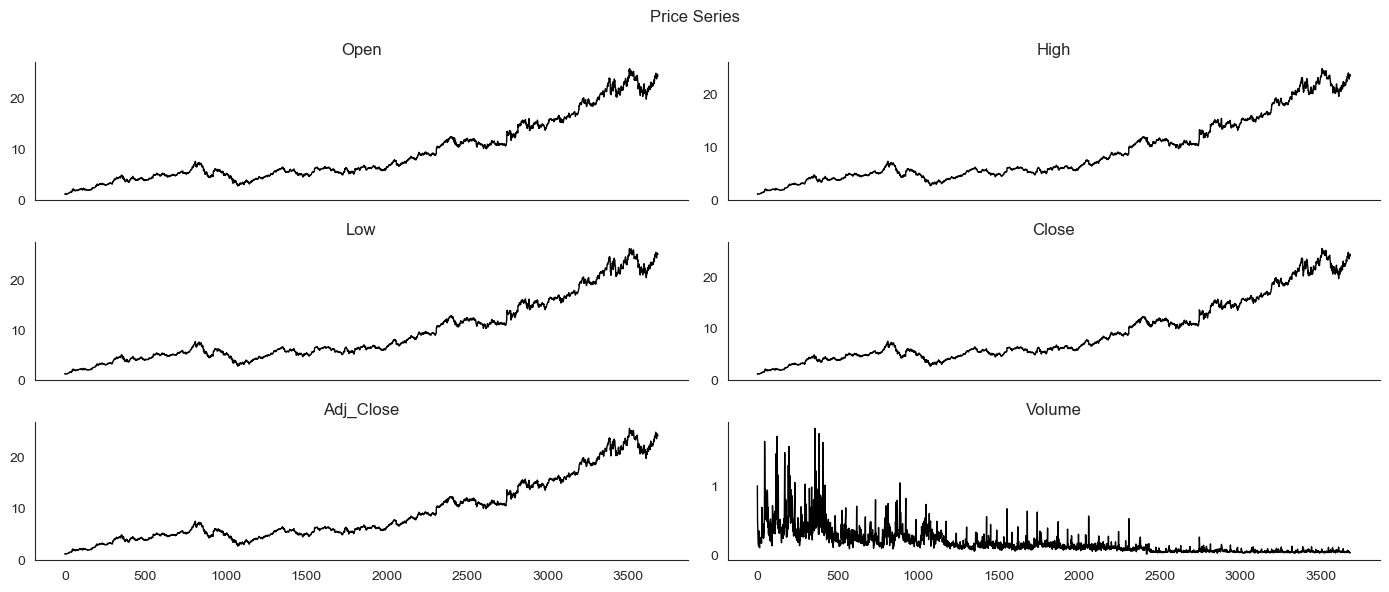

In [17]:
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=features,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Price Series')
plt.gcf().tight_layout()
sns.despine()

### 3.3. Correlation

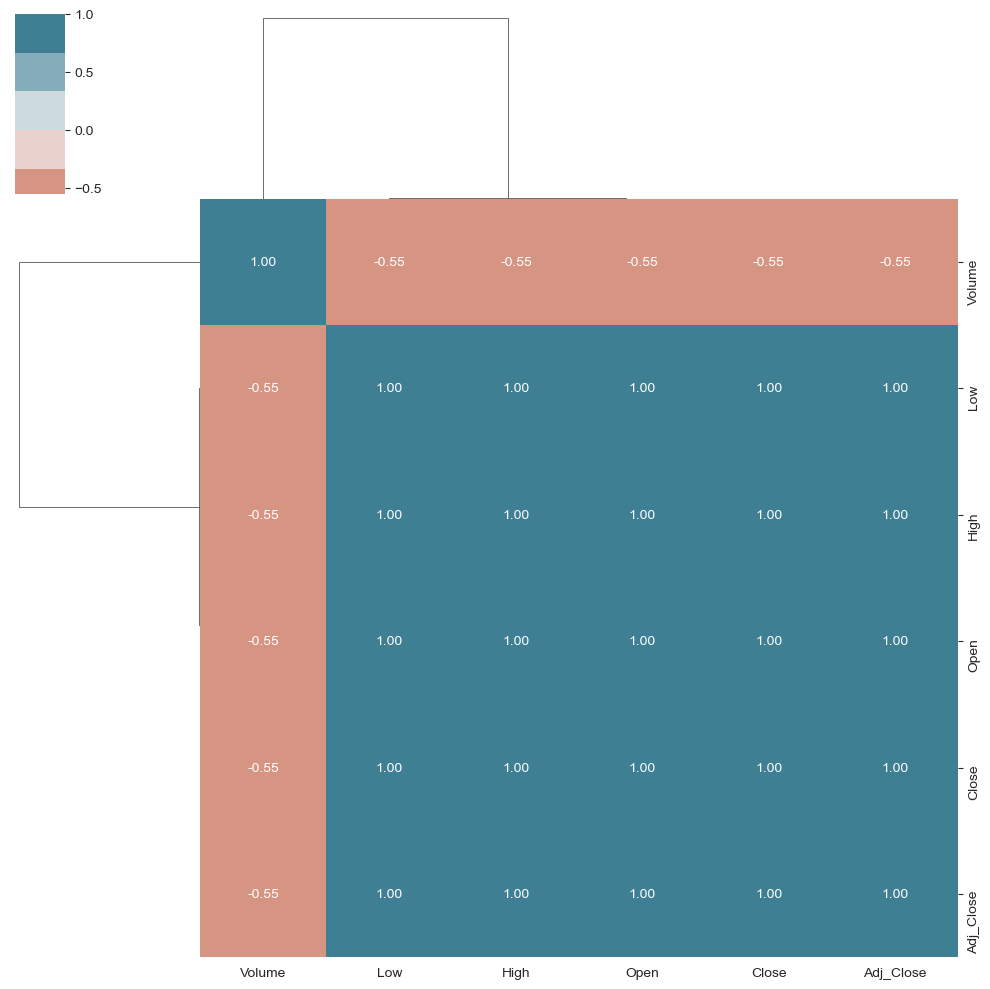

In [18]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

### 3.4. Normalize Data

In [19]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

### 3.5. Create rolling window sequences

In [20]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

### 3.6. Create tf.data.Dataset

In [21]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle( # mix the datasets (to make it similar to i.i.d.)
                    buffer_size=n_windows, 
                    seed=RANDOM_SEED
                ) 
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-08 18:48:32.729903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 18:48:32.729927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3.7. Set up random series generator

In [22]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [23]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

2023-02-08 18:48:32.900523: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## 4. TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

### 4.1. Network Parameters

In [24]:
hidden_dim = n_seq * 4
num_layers = 3

### 4.2. Set up logger

In [25]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

### 4.3. Input place holders

In [26]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

### 4.4. RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [27]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

### 4.5. Embedder & Recovery

In [28]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

### 4.6. Generator & Discriminator

In [29]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

## 5. TimeGAN Training

### 5.1. Settings

In [30]:
# iterations = 10000 in blog post, took ~2.5 hours
# iterations = 50000 in original paper
train_steps = 50000
gamma = 1

### 5.2. Generic Loss Functions

In [31]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

## 6. Phase 1: Autoencoder Training

### 6.1. Architecture

In [32]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [33]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


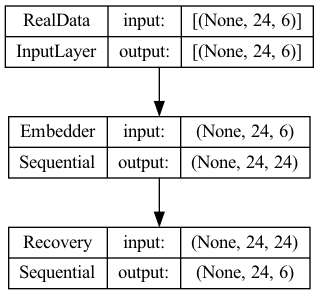

In [34]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

### 6.2. Autoencoder Optimizer

In [35]:
autoencoder_optimizer = Adam()

### 6.3. Autoencoder Training Step

In [36]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### 6.4. Autoencoder Training Loop

In [37]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

  0%|          | 0/50000 [00:00<?, ?it/s]2023-02-08 18:48:35.908960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.343508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.409083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.465245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.525212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.580915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 18:48:36.636376: I

GOOGLE_BIG: 10000/10000 [07:40<00:00, 21.72it/s]

### 6.5. Persist model

In [38]:
# autoencoder.save(log_dir / 'autoencoder')

## 7. Phase 2: Supervised training

### 7.1. Define Optimizer

In [39]:
supervisor_optimizer = Adam()

### 7.2. Train Step

In [40]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        # g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :]) # from blog post
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

### 7.3. Training Loop

In [41]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

  0%|          | 0/50000 [00:00<?, ?it/s]2023-02-08 19:28:31.159058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.498827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.560846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.615559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.672351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.732500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-08 19:28:31.822951: I

GOOGLE_BIG: 10000/10000 [04:28<00:00, 37.29it/s]

### 7.4. Persist Model

In [ ]:
# supervisor.save(log_dir / 'supervisor')

## 8. Joint Training

### 8.1. Generator

#### 8.1.1. Adversarial Architecture - Supervised

In [ ]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

#### 8.1.2. Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

#### 8.1.3. Mean & Variance Loss

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [ ]:
synthetic_data.summary()

In [ ]:
plot_model(synthetic_data, show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### 8.2. Discriminator

#### 8.2.1. Architecture: Real Data

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

In [ ]:
plot_model(discriminator_model, show_shapes=True)

### 8.3. Optimizers

In [ ]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

### 8.4. Generator Train Step

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### 8.5. Embedding Train Step

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)
        e_loss = e_loss_0 + 0.1 * g_loss_s

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### 8.6. Discriminator Train Step

In [ ]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

### 8.7. Training Loop

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

GOOGLE_BIG: (attempt 2)
- Fixed supervisor loss according to original code)
- Start: 1:43

| step? | G Loss S | G Loss U | G Loss V | E Loss T0 | D Loss | 
| --- | --- | --- | --- | --- | --- |
| 0 | d_loss: 2.2243 | g_loss_u: 0.6643 | g_loss_s: 0.0000 | g_loss_v: 0.6156 | e_loss_t0: 0.0470 
| 1,000 | d_loss: 1.5633 | g_loss_u: 1.1609 | g_loss_s: 0.0000 | g_loss_v: 0.3569 | e_loss_t0: 0.0365
| 2,000 | d_loss: 0.2811 | g_loss_u: 3.1629 | g_loss_s: 0.0001 | g_loss_v: 0.6501 | e_loss_t0: 0.0431
| 3,000 | d_loss: 0.1914 | g_loss_u: 3.4952 | g_loss_s: 0.0393 | g_loss_v: 0.6104 | e_loss_t0: 0.0549
|4,000 | d_loss: 0.5600 | g_loss_u: 4.1412 | g_loss_s: 0.1094 | g_loss_v: 0.2825 | e_loss_t0: 0.0503
| 5,000 | d_loss: 0.1652 | g_loss_u: 6.5578 | g_loss_s: 0.0383 | g_loss_v: 0.2855 | e_loss_t0: 0.0373
| 6,000 | d_loss: 0.1594 | g_loss_u: 5.6045 | g_loss_s: 0.0330 | g_loss_v: 0.3608 | e_loss_t0: 0.0489
| 7,000 | d_loss: 0.1902 | g_loss_u: 8.0011 | g_loss_s: 0.0232 | g_loss_v: 0.5577 | e_loss_t0: 0.0504

GOOGLE_BIG:  

| step? | G Loss S | G Loss U | G Loss V | E Loss T0 | D Loss | 
| --- | --- | --- | --- | --- | --- |
|0 | d_loss: 2.0486 | g_loss_u: 0.8183 | g_loss_s: 0.0042 | g_loss_v: 0.7469 | e_loss_t0: 0.0417 |
| 1,000 | d_loss: 0.1299 | g_loss_u: 3.3986 | g_loss_s: 0.0532 | g_loss_v: 0.7612 | e_loss_t0: 0.0427 |
| 2,000 | d_loss: 0.1065 | g_loss_u: 5.1381 | g_loss_s: 0.1472 | g_loss_v: 0.7678 | e_loss_t0: 0.0349 |
| 3,000 | d_loss: 1.0576 | g_loss_u: 1.0446 | g_loss_s: 0.0542 | g_loss_v: 0.5752 | e_loss_t0: 0.0521 |
| 4,000 | d_loss: 0.1406 | g_loss_u: 4.6089 | g_loss_s: 0.1230 | g_loss_v: 0.5067 | e_loss_t0: 0.0417 |
| 5,000 | d_loss: 0.1104 | g_loss_u: 4.0239 | g_loss_s: 0.2800 | g_loss_v: 0.6347 | e_loss_t0: 0.0401 |
| 6,000 | d_loss: 0.1212 | g_loss_u: 4.0914 | g_loss_s: 0.2253 | g_loss_v: 0.4564 | e_loss_t0: 0.0451 |
| 7,000 | d_loss: 0.0985 | g_loss_u: 4.0673 | g_loss_s: 0.1251 | g_loss_v: 0.5122 | e_loss_t0: 0.0402 |
| 8,000 | d_loss: 0.0949 | g_loss_u: 4.5053 | g_loss_s: 0.0323 | g_loss_v: 0.4036 | e_loss_t0: 0.0440 |
| 9,000 | d_loss: 0.0827 | g_loss_u: 4.5532 | g_loss_s: 0.0741 | g_loss_v: 0.5130 | e_loss_t0: 0.0657 |

~2.5 hours

### 8.8. Persist Synthetic Data Generator

In [ ]:
synthetic_data.save(log_dir / 'synthetic_data')

## 9. Generate Synthetic Data

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

In [ ]:
np.save(log_dir / 'generated_data.npy', generated_data)

### 9.1. Rescale

In [ ]:
generated_data = (scaler.inverse_transform(
                    generated_data.reshape(-1, n_seq)
                ).reshape(-1, seq_len, n_seq))

generated_data.shape

### 9.2. Persist Data

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=features))

### 9.3. Plot sample Series

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, feature in enumerate(features):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=feature,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()